In [44]:
import os
from typing import Annotated

from IPython.display import Image, display
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage
from langchain_ollama import ChatOllama
from langchain_tavily import TavilySearch
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, field_serializer

In [45]:
os.environ["LANGCHAIN_PROJECT"] = "ReActAgent"

In [25]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
arxiv.name

'arxiv'

In [26]:
result = arxiv.invoke("Attention is all you need.")

In [27]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [28]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [29]:
tavily = TavilySearch()

In [30]:
tools = [arxiv, wiki, tavily]
llm = ChatOllama(model="qwen2.5")
llm = llm.bind_tools(tools=tools)

In [31]:
llm.invoke([HumanMessage(content="What is the recent AI news?")]).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'recent AI news',
   'search_depth': 'advanced',
   'time_range': 'week'},
  'id': '7c0a7f63-3641-4b47-bd38-54e9cf9efb9e',
  'type': 'tool_call'}]

In [32]:
class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

    @field_serializer
    def messages_serializers(self, messages: list[AnyMessage]) -> list[dict]:
        return [message.model_dump() for message in messages]


class LlmWithTools:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        return dict(messages=llm.invoke(state.messages))

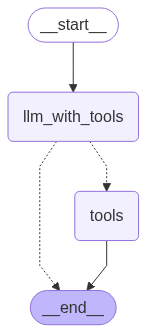

In [33]:
builder = StateGraph(State)
builder.add_node("llm_with_tools", LlmWithTools(llm))
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges("llm_with_tools", tools_condition)
builder.add_edge("llm_with_tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
result = graph.invoke(
    dict(messages=[HumanMessage(content="1706.03762", name="Hyan")])
)

In [42]:
_ = [message.pretty_print() for message in result.get("messages")]

================================ Human Message =================================
Name: Hyan

1706.03762
================================== Ai Message ==================================

It seems like you're referencing an ArXiv paper by its identifier (1706.03762). Would you like me to fetch the summary or abstract of this paper for you? If so, I will use the `arxiv` function to do that.
Tool Calls:
  arxiv (d1a8fcbc-dd48-4cda-a497-21a8f06b1a78)
 Call ID: d1a8fcbc-dd48-4cda-a497-21a8f06b1a78
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect th

In [43]:
result = graph.invoke(
    dict(messages=[HumanMessage(content="Provide the 10 most recent AI news of today.", name="Hyan")])
)
_ = [message.pretty_print() for message in result.get("messages")]

================================ Human Message =================================
Name: Hyan

Provide the 10 most recent AI news of today.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (d7fb7b47-40b8-4814-8398-02ca8bf6d4c4)
 Call ID: d7fb7b47-40b8-4814-8398-02ca8bf6d4c4
  Args:
    query: AI news
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/artificial-intelligence-news/", "title": "TechForge - AI News", "content": "The technical storage or access is required to create user profiles to send advertising, or to track the user on a website or across several websites for similar marketing purposes.\n\nManage optionsManage servicesManage {vendor_count} vendorsRead more about these purpo